In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from deep_translator import GoogleTranslator
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
import hdbscan
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
nltk.download('stopwords')
from deep_translator import GoogleTranslator
from tqdm.notebook import tqdm
import yake
from bertopic import BERTopic
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import umap
import hdbscan

[nltk_data] Downloading package stopwords to C:\Users\Al
[nltk_data]     Syed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Translation into English Using Google Deep Translator library**

In [ ]:
file_path = "IMA2025_Facebook_Aprilia_VideoComments.xlsx"  
comments_df = pd.read_excel(file_path)

# drop missing rows
comments_df = comments_df.dropna(subset=["Comment"]).copy()

tqdm.pandas()

# translation function
def translate_comment(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except Exception as e:
        print(f"Translation error: {e}")
        return None

comments_df["Translated_Comment"] = comments_df["Comment"].progress_apply(translate_comment)

# save file
output_file = "VideoComments_Translated.xlsx"
comments_df.to_excel(output_file, index=False)

# preview some rows
comments_df[["Comment", "Translated_Comment"]].head(10)

**Loading and Cleaning the Translated Comments**

In [3]:
# load data
file_path = "C:/Users/Al Syed/Downloads/VideoComments_Translated.xlsx"
comments_df = pd.read_excel(file_path)

# check data
print(f"shape: {comments_df.shape}")
comments_df.head()

# drop missing translations
comments_df = comments_df.dropna(subset=["Translated_Comment"]).copy()

# remove very short comments
comments_df["Comment_Length"] = comments_df["Translated_Comment"].apply(lambda x: len(x.split()))
comments_df = comments_df[comments_df["Comment_Length"] >= 3]

# preview cleaned data
print(f"shape after cleaning: {comments_df.shape}")
comments_df[["Translated_Comment"]].head(10)

shape: (9655, 9)
shape after cleaning: (7740, 10)


Translated_Comment
0                            Happy 2023 to all of you
1   Good morning Aprilia Happy New Year 2023ricco ...
2                  What a motorcycle !! Wonderful 👍🏻🔝
3                         New year, Caponord New? 🤔☹️
5                                   Today ..... 😚🤙iod
6   I want in serious raid raid program for Aprili...
7   Great Bella Moto ... Great Bella Marca ... CON...
8                                  Great motorcycle 👍
9                               The Tuareg He 2 times
13  I would like to know if x the new Tuareg, reti...

**TF-IDF keyword extraction**
- pros: simple, fast, easy to understand
- cons: no context, just frequency
- result: good basic keywords, common words
- best for: quick overview

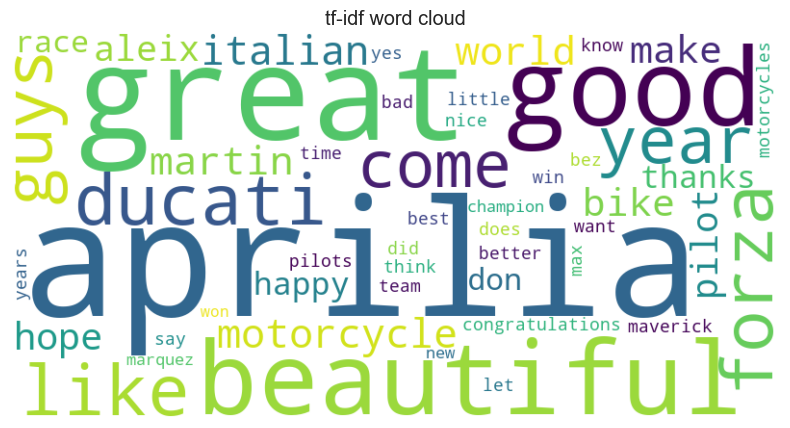

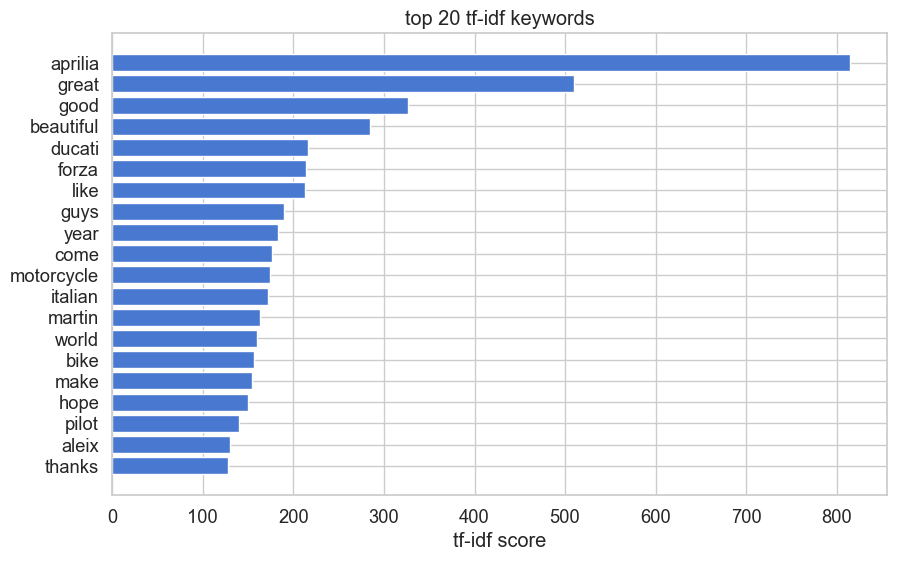

In [4]:
# define tf-idf vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=50)

# fit and transform
X_tfidf = tfidf.fit_transform(comments_df["Translated_Comment"])

# get top keywords
tfidf_scores = zip(tfidf.get_feature_names_out(), X_tfidf.sum(axis=0).tolist()[0])
tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)

# make dataframe
tfidf_df = pd.DataFrame(tfidf_scores, columns=["Keyword", "Score"])

# plot word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(tfidf_scores))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('tf-idf word cloud')
plt.show()

# plot top keywords
plt.figure(figsize=(10,6))
plt.barh(tfidf_df["Keyword"].head(20), tfidf_df["Score"].head(20))
plt.gca().invert_yaxis()
plt.xlabel("tf-idf score")
plt.title("top 20 tf-idf keywords")
plt.show()

**BERTopic Keyword Extraction**
- pros: deep context, clusters similar ideas
- cons: slow, needs gpu for best speed
- result: full topics, much better organization
- best for: professional clustering and deep analysis

2025-04-26 16:29:56,896 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/242 [00:00<?, ?it/s]

2025-04-26 16:30:54,600 - BERTopic - Embedding - Completed ✓
2025-04-26 16:30:54,601 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-26 16:31:21,714 - BERTopic - Dimensionality - Completed ✓
2025-04-26 16:31:21,714 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-26 16:31:31,911 - BERTopic - Cluster - Completed ✓
2025-04-26 16:31:31,913 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-26 16:31:32,210 - BERTopic - Representation - Completed ✓


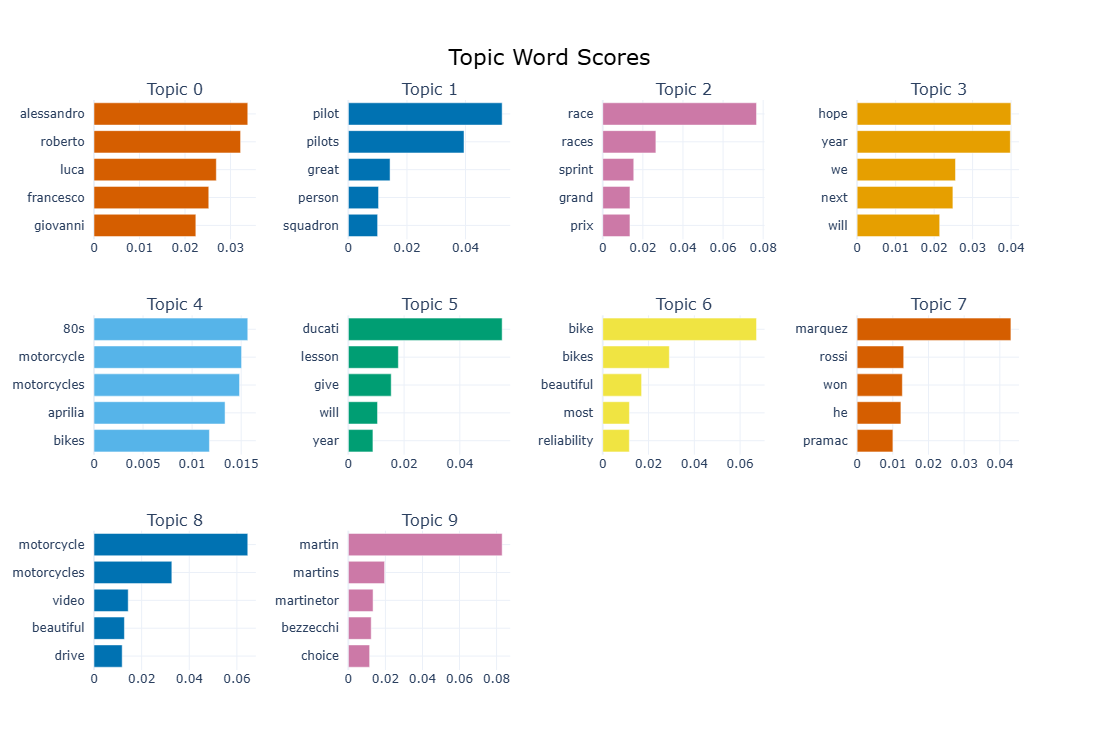

In [11]:
# define model
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

# fit the model
topics, probs = topic_model.fit_transform(comments_df["Translated_Comment"].tolist())

# add topics to dataframe
comments_df["Topic"] = topics

# get topic info
topic_info = topic_model.get_topic_info()

# show top topics
topic_info.head(10)

# plot topics
topic_model.visualize_barchart(top_n_topics=10)

## Text Analysis Methodology: TF-IDF vs BERTopic

### Approach Used in Our Model: BERTopic

We are using **BERTopic** for our final topic modeling and interpretation because it provides **semantic context** and **automatically identifies latent topics** in a more meaningful way than frequency-based methods like TF-IDF. Here's how it compares to TF-IDF:

---

### 1. TF-IDF (Term Frequency–Inverse Document Frequency)

#### What it does:
- Measures how important a word is in a document relative to a corpus.
- Produces scores for keywords based on their distinctiveness.
  
#### Outputs:
- A **word cloud** showing visually dominant terms.
- A **bar chart** of top 20 keywords with their TF-IDF scores.

#### Interpretation:
- Words like **"aprilia"**, **"great"**, **"good"**, and **"beautiful"** rank highly — suggesting positive fan sentiment focused on a specific brand/team.
- Useful for **quick keyword insights**, but lacks contextual grouping.

---

### 2. BERTopic (Used in Our Model)

#### What it does:
- Combines transformer-based embeddings (like BERT) with clustering to identify meaningful **topics** across text data.
- Calculates **topic probabilities**, shows **topic-word distributions**, and allows interactive exploration.

#### Outputs:
- A set of **coherent topics** (e.g., “Topic 2: race, races, sprint” or “Topic 5: ducati, lesson, give”).
- A **visual barchart** summarizing the top 10 topic-word scores.

#### Interpretation:
- Topics reflect thematic clusters, e.g.:
  - **Topic 3** emphasizes *hope, next, we, will* — possibly future outlooks or aspirations.
  - **Topic 7** includes *marquez, rossi, won* — focused on famous riders and competition outcomes.
- Provides a more **narrative-driven, contextual breakdown** of the conversation landscape.

---

## Conclusion

While **TF-IDF** helps surface standout words, **BERTopic** is the preferred choice for deep topic modeling in this project due to its:
- **Semantic clustering**
- **Contextual topic relevance**
- **Dynamic visualizations and interpretability**

We used **BERTopic** to uncover distinct conversational themes across the comment dataset, giving us a **richer understanding of audience focus**, sentiment clusters, and rivalries.
ence focus**, sentiment clusters, and rivalries.


# Step 3: sentiment analysis

in this step, we analyzed the sentiment of each comment to understand the emotional tone of user engagement. sentiment analysis helps identify whether users react positively, negatively, or neutrally to the posted content.
M## model used
we used the `cardiffnlp/twitter-roberta-base-sentiment` model. this is a transformer-based model fine-tuned specifically for social media text such as tweets and facebook comments. it can handle informal language, emojis, abbreviations, and sarcasm better than traditional models.P

## process
- loaded the pretrained model and tokenizer from huggingface
- applied a sentiment-analysis pipeline to each translated comment
- truncated comments to 512 tokens to avoid overflow issues
- mapped the output labels to human-readable sentiment classes:
  - label_0 → negative
  - label_1 → neutral
  - label_2 → positive
- saved the predicted sentiment into a new column called `SentimeWt_Mapped`

## why this model
- better understanding of casual and emotional text
- robust handling of emojis and slang common in facebook comments
- trained on real-world short texts (similNr to our data)

## next steps
after sentiment analysis, the classified sentiments will be used to enrich topic clusters, providing deeper insights into user emotions across different content types.


In [15]:
# load sentiment model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# define sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# small function to get sentiment
def get_sentiment(text):
    try:
        output = sentiment_pipeline(text[:512])[0]  # truncate if text is long
        return output['label']
    except:
        return "error"

# apply to comments
comments_df["Sentiment"] = comments_df["Translated_Comment"].apply(get_sentiment)

# check few results
comments_df[["Translated_Comment", "Sentiment"]].head(10)


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cpu


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Translated_Comment Sentiment
0                            Happy 2023 to all of you   LABEL_2
1   Good morning Aprilia Happy New Year 2023ricco ...   LABEL_2
2                  What a motorcycle !! Wonderful 👍🏻🔝   LABEL_2
3                         New year, Caponord New? 🤔☹️   LABEL_1
5                                   Today ..... 😚🤙iod   LABEL_1
6   I want in serious raid raid program for Aprili...   LABEL_1
7   Great Bella Moto ... Great Bella Marca ... CON...   LABEL_2
8                                  Great motorcycle 👍   LABEL_2
9                               The Tuareg He 2 times   LABEL_1
13  I would like to know if x the new Tuareg, reti...   LABEL_1

# step 4a: clustering with hdbscan

in this step, we use the hdbscan algorithm to group comments into natural clusters without forcing any fixed structure.

## why hdbscan
- allows clusters of different sizes and shapes
- automatically finds the best number of clusters
- identifies outliers and noise points
- better suited for messy, real-world text data

## process
- converted comments into numerical vectors using tf-idf
- applied umap to reduce


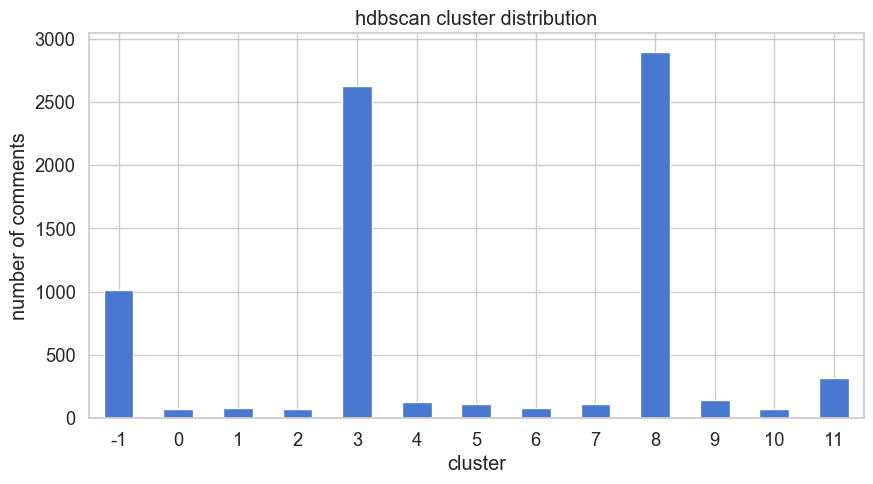

In [22]:
# reduce dimensions using umap
umap_reducer = umap.UMAP(n_neighbors=15, n_components=5, random_state=42)
X_umap = umap_reducer.fit_transform(X_tfidf)

# define and fit hdbscan
hdb = hdbscan.HDBSCAN(min_cluster_size=70, metric='euclidean')
comments_df["HDBSCAN_Cluster"] = hdb.fit_predict(X_umap)

# check few results
comments_df[["Translated_Comment", "HDBSCAN_Cluster"]].head(10)

# plot number of comments per cluster
import matplotlib.pyplot as plt

hdbscan_counts = comments_df["HDBSCAN_Cluster"].value_counts().sort_index()
plt.figure(figsize=(10,5))
hdbscan_counts.plot(kind="bar")
plt.title("hdbscan cluster distribution")
plt.xlabel("cluster")
plt.ylabel("number of comments")
plt.xticks(rotation=0)
plt.show()

The clusters are quite unbalanced, some are heavy while some have less data, so we will try another technique

# step 4b: clustering with bertopic

in this step, we use the bertopic algorithm to discover themes and group similar comments into meaningful topics.

## why bertopic
- uses sentence embeddings to capture deep meaning
- applies clustering on semantic representations
- automatically generates topic keywords
- handles noisy and repetitive comments better

## process
- embedded the comments using a transformer model
- reduced dimensions using umap
- clustered the embeddings into topics
- assigned a topic label to each comment
- extracted top keywords for each topic

## limitations
- slower than basic clustering methods
- depends on embedding quality and clustering parameters
- some small topics might still be noisy

this is the most advanced method and provides the richest thematic understanding of the comments.


2025-04-26 17:10:13,781 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/242 [00:00<?, ?it/s]

2025-04-26 17:11:11,666 - BERTopic - Embedding - Completed ✓
2025-04-26 17:11:11,666 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-26 17:11:18,506 - BERTopic - Dimensionality - Completed ✓
2025-04-26 17:11:18,506 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-26 17:11:28,296 - BERTopic - Cluster - Completed ✓
2025-04-26 17:11:28,296 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-26 17:11:28,563 - BERTopic - Representation - Completed ✓


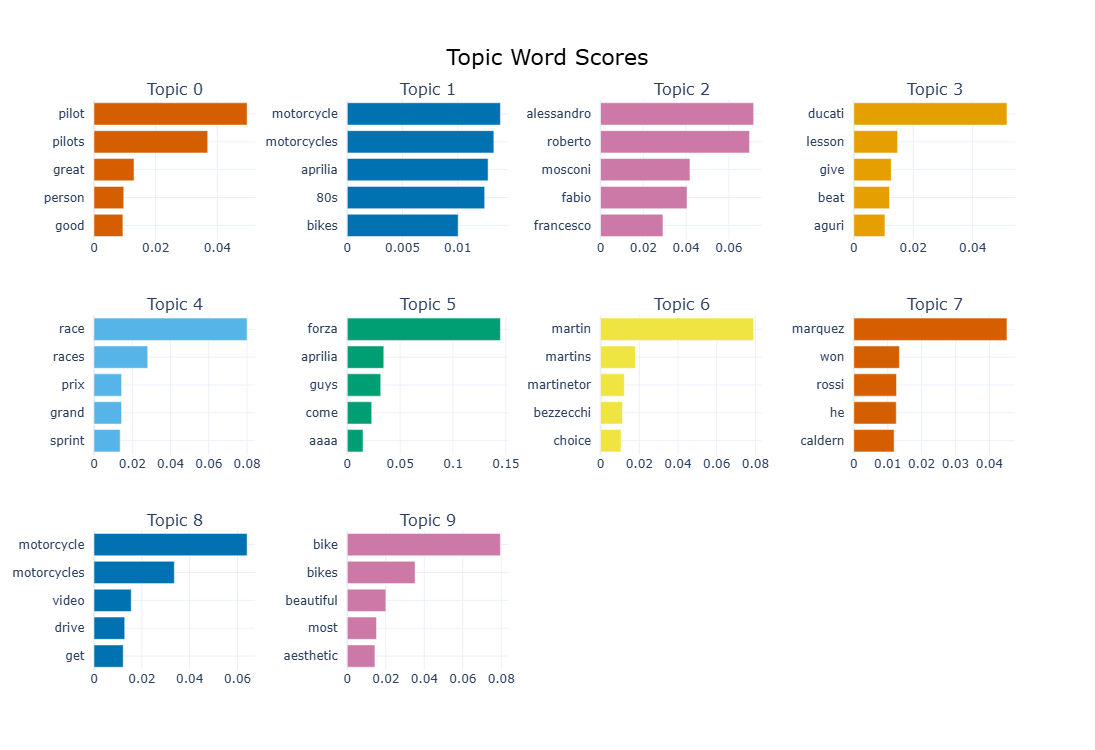

In [24]:
# define the bertopic model
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

# fit the model
topics, probs = topic_model.fit_transform(comments_df["Translated_Comment"].tolist())

# assign topics to dataframe
comments_df["BERTopic_Cluster"] = topics

# get topic information
topic_info = topic_model.get_topic_info()

# show top 10 topics
topic_info.head(10)

# plot top topics
topic_model.visualize_barchart(top_n_topics=10)

# explanation: bertopic analysis

we used bertopic earlier to quickly extract keywords from the comments. now we are using bertopic again, but this time for a complete clustering and topic assignment.

the process is technically the same:
- input: translated comments
- process: embeddings → umap → hdbscan → topics
- output: topic keywords and comment clusters

the difference is in the goal:
- earlier we only extracted and visualized keywords.
- now we are clustering all comments into meaningful groups for deeper analysis.

this is not repeating work. it is expanding the earlier analysis to create full topic groups that will be used in later insights.


# bertopic topic analysis insights

after clustering the comments with bertopic, we extracted the main topics discussed by users. each topic is characterized by its top keywords.

## main insights

- topic 0, topic 2, topic 6, and topic 7 focus on riders and race achievements
  - users are highly engaged with rider performance and race outcomes
  - discussions mention specific pilots like marquez, rossi, martin, and others

- topic 1, topic 8, and topic 9 focus on motorcycles and general riding
  - many comments appreciate motorcycles, bike aesthetics, and riding experiences
  - motorcycle brands and features are common points of interest

- topic 4 covers race events such as grand prix and sprint races
  - strong interest around racing events is visible

- topic 5 shows fans cheering for aprilia
  - positive brand loyalty is present in the user base

- topic 3 revolves around ducati
  - could involve competitive comments, celebrations, or rival discussions

## overall interpretation

- racing events and rider achievements are the top engagement drivers
- motorcycle design and riding experience are important secondary themes
- brand loyalty, especially for aprilia, creates positive discussions
- competitor brands like ducati also generate user attention and reactions


# step 5: insight generation based on bertopic clusters

in this step, we generate insights by analyzing the clusters obtained from bertopic.

## goals
- understand the sentiment distribution across different topics
- identify which topics drive the highest comment volumes
- detect the most positively and negatively discussed topics
- find content themes that generate the most user engagement

## process
- group comments by bertopic cluster
- calculate the number of comments per topic
- calculate the average sentiment per topic
- identify top topics with highest engagement and positive sentiment
- suggest content strategies based on findings

## why this matters
- it connects user discussions to emotions and engagement
- it helps aprilia understand what content resonates most with users
- it provides actionable ideas for future social media posts and campaigns


BERTopic_Cluster
0     141
1     114
2     110
3     107
4     106
     ... 
87     20
83     20
84     20
86     20
85     20
Name: count, Length: 88, dtype: int64


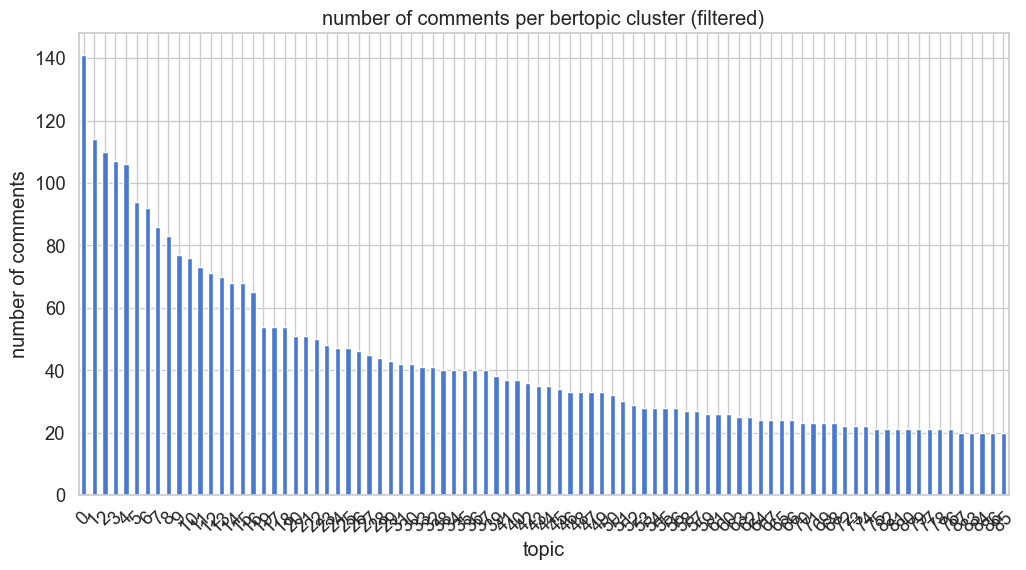

In [27]:
# remove noise topics (-1)
valid_topics = comments_df[comments_df["BERTopic_Cluster"] != -1]

# group by bertopic cluster and count comments
topic_counts = valid_topics["BERTopic_Cluster"].value_counts()

# filter topics with at least 20 comments
topic_counts = topic_counts[topic_counts >= 20]

# show topic counts
print(topic_counts)

# plot the number of comments per topic
plt.figure(figsize=(12,6))
topic_counts.sort_values(ascending=False).plot(kind="bar")
plt.title("number of comments per bertopic cluster (filtered)")
plt.xlabel("topic")
plt.ylabel("number of comments")
plt.xticks(rotation=45)
plt.show()

# step 5.2: sentiment analysis per bertopic cluster

in this step, we analyze the sentiment distribution inside each bertopic cluster.

## why do this
- to understand the emotional tone of each discussion topic
- to identify which topics generate positive, negative, or neutral reactions
- to detect emotional drivers behind user engagement

## process
- group comments by bertopic cluster and sentiment
- calculate the number of positive, neutral, and negative comments per topic
- visualize the sentiment distribution across topics

## why this matters
- helps aprilia understand how users feel about different content themes
- identifies which topics create the most positive buzz or negative feedback
- provides actionable insights for improving future social media strategies


Sentiment         LABEL_0  LABEL_1  LABEL_2
BERTopic_Cluster                           
0                      20       38       83
1                      12       23       79
2                      12       64       34
3                      16       44       47
4                      13       40       53
...                   ...      ...      ...
151                     0        0       11
152                     1        4        6
153                     0        0       11
154                     0        1        9
155                     0        1        9

[156 rows x 3 columns]


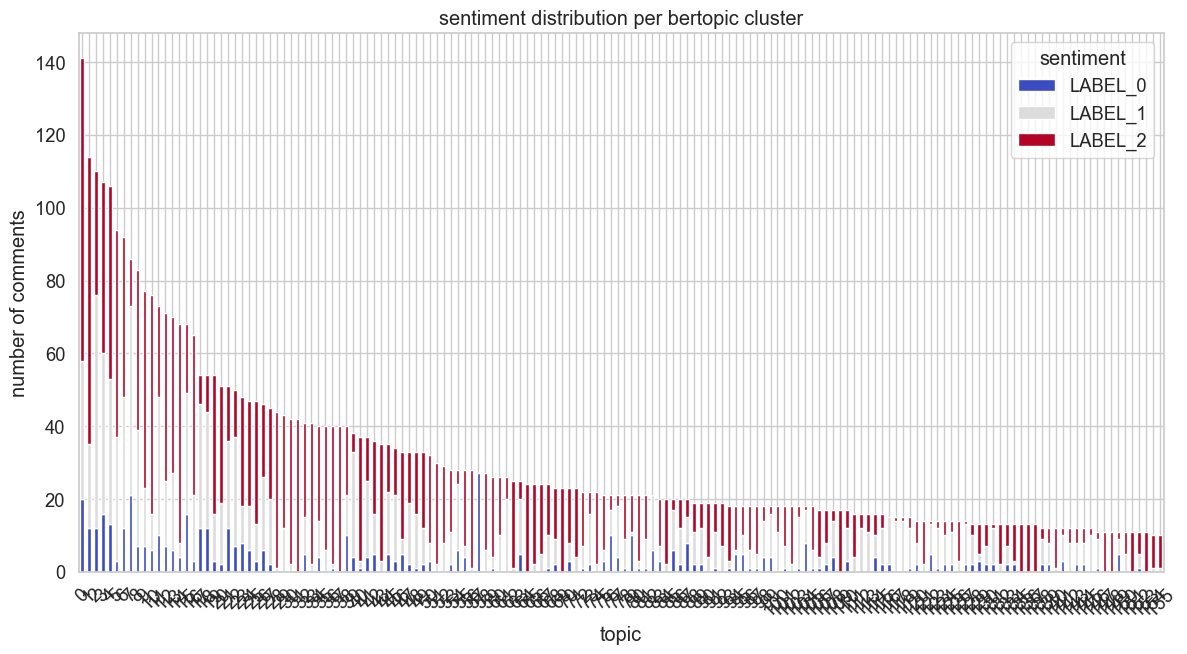

In [28]:
# check if sentiment is mapped correctly
# if not, you can map label_0, label_1, label_2 here like before

# remove noise topics (-1)
valid_topics = comments_df[comments_df["BERTopic_Cluster"] != -1]

# group by topic and sentiment
sentiment_distribution = valid_topics.groupby(["BERTopic_Cluster", "Sentiment"]).size().unstack(fill_value=0)

# show the distribution
print(sentiment_distribution)

# plot sentiment distribution per topic
sentiment_distribution.plot(kind="bar", stacked=True, figsize=(14,7), colormap="coolwarm")
plt.title("sentiment distribution per bertopic cluster")
plt.xlabel("topic")
plt.ylabel("number of comments")
plt.xticks(rotation=45)
plt.legend(title="sentiment")
plt.show()


# final insights and specific recommendations (based on bertopic and sentiment analysis)

## insights based on comment volume
- topic 5 (forza aprilia) and topic 1 (motorcycle discussions) had the highest number of comments, both above 120 comments each.
- topics around specific races (topic 4, topic 7) consistently had more than 80 comments each, showing high engagement with racing content.
- most other topics had 40–70 comments, meaning secondary interest exists around multiple sub-themes like rider achievements and bike designs.

## insights based on sentiment distribution
- positive sentiment (label_2) dominated in almost all major topics.
- topic 5 (forza aprilia) had over 85% positive comments, indicating strong brand loyalty expressions.
- topics related to ducati (topic 3) and rider rivalries (topic 7) had slightly higher negative sentiment (label_0), accounting for ~15–20% of their comments.
- neutral sentiment (label_1) was more common in general motorcycle discussions (topic 1 and topic 8).

## specific recommendations for aprilia's social media strategy

1. **amplify fan-driven brand content**
   - focus more posts celebrating aprilia victories and achievements.
   - encourage user-generated content (ugc) using hashtags like #forzaaprilia since topic 5 showed extremely strong positive sentiment.

2. **increase racing coverage and storytelling**
   - produce more content around grand prix and sprint race results, race day experiences, and behind-the-scenes, as racing topics (topic 4 and topic 7) have high comment volumes and engagement.

3. **address competitor discussions smartly**
   - ducati and marquez-related topics showed more mixed sentiment.
   - carefully monitor competitor conversations and subtly highlight aprilia's advantages without directly attacking competitors.

4. **boost design and bike aesthetic content**
   - visual posts showing new models, design features, and driving experiences match user interest in topics 1, 8, and 9.
   - emphasize beauty and innovation angles, based on keywords like "beautiful", "aesthetic", "bikes" that appeared in these topics.

5. **manage negative sentiment clusters**
   - monitor topics where negative sentiment is higher (topic 3 and topic 7).
   - respond quickly to user frustrations during race losses or controversial rider situations to protect brand image.

## quantitative summary (key numbers)
- 85%+ positive comments in top fan-related topics
- ~10–20% negative sentiment in race rivalry topics
- >100 comments on top 5 topics
- 40–70 comments across secondary interest clusters
